In [3]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LassoCV, ElasticNet
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel
from sklearn.preprocessing import Binarizer, Imputer, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.svm import LinearSVC, SVC

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline

In [4]:
df = pd.read_csv('train.csv')
df.shape

(2051, 82)

In [5]:
# Remove spaces in column names
df.columns = [c.replace(' ', '_') for c in df.columns]

In [6]:
# set target column as binary
df['Sale_Condition'] = df['Sale_Condition'].map(lambda x: 1 if x == 'Abnorml' else 0)
df['Sale_Condition'].value_counts()


0    1919
1     132
Name: Sale_Condition, dtype: int64

In [7]:
df.MS_Zoning.value_counts()

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MS_Zoning, dtype: int64

In [8]:
# make MS_Zoning feature binary: all residential rows as 1 and others 0
def ms_zoning(zone):
    if zone in ['RL', 'RM', 'FV', 'RH', 'RP']:
        zone = 1
    if zone in ['C (all)', 'A (agr)', 'I (all)']:
        zone = 0
    return zone

df['MS_Zoning'] = df['MS_Zoning'].apply(ms_zoning)
    
    

In [9]:
def sale_type(type):
    if 'WD' in type:
        type = 1
    elif 'New' in type:
        type = 1
    elif 'CWD' in type:
        type = 1
    elif 'VWD' in type:
        type = 1
    elif type in ['Con', 'Oth', 'ConLw', 'ConLI', 'COD','ConLD']:
        type = 0
    else:
        type=type
    return type

df['Sale_Type'] = df['Sale_Type'].apply(sale_type)

In [10]:
# BldgType
df.Bldg_Type.value_counts()

1Fam      1700
TwnhsE     161
Duplex      75
Twnhs       69
2fmCon      46
Name: Bldg_Type, dtype: int64

In [11]:
# def bldg_type(type):
#     if '1Fam' in type:
#         type = 1
#     elif type in ['TwnhsE', 'Duplex', 'Twnhs', '2fmCon']:
#         type = 0
#     return type

# df['Bldg_Type'] = df['Bldg_Type'].apply(bldg_type)
    
    

In [12]:
#HouseStyle
df.House_Style.value_counts()

1Story    1059
2Story     598
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: House_Style, dtype: int64

In [13]:
# def house_style(type):
#     if '1Story' in type:
#         type = 0
#     elif type in ['1.5Fin', '1.5Unf', 'SLvl', 'SFoyer']:
#         type = 1
#     else:
#         type = 2
#     return type

# df['House_Style'] = df['House_Style'].apply(house_style)
    
    

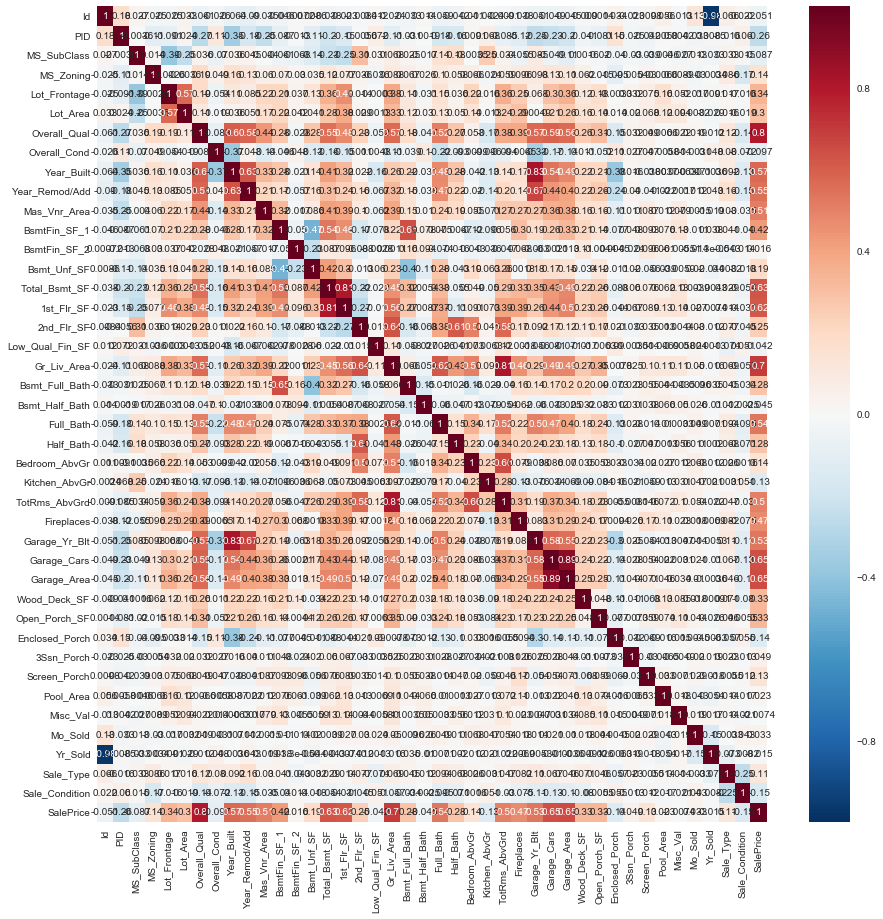

In [14]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True)

In [15]:
# make a DF with the correlated features
# this makes is so only numerical features are used
correlated_price = df.corr().abs()['Sale_Condition'].sort_values(ascending=False)
corr_df = pd.DataFrame(correlated_price)
corr_df.index


X_cols = list(corr_df.index)

# create list to use for X. Remove 'SalePrice' since it is not in the Test.csv
X_column_names = [x for x in X_cols if x != 'SalePrice']

# create new dataframe with only the numerical data to more easily impute nulls
df_numbers = df[X_column_names]

In [16]:
corr_df

,Sale_Condition
Sale_Condition,1.000000
Sale_Type,0.254306
MS_Zoning,0.165571
Year_Remod/Add,0.148806
SalePrice,0.145943
Overall_Qual,0.143246
Year_Built,0.132671
Garage_Cars,0.128731
Garage_Yr_Blt,0.110609
Garage_Area,0.101632


In [17]:
df_numbers.head()

,Sale_Condition,Sale_Type,MS_Zoning,Year_Remod/Add,Overall_Qual,Year_Built,Garage_Cars,Garage_Yr_Blt,Garage_Area,Full_Bath,...,Pool_Area,Lot_Frontage,MS_SubClass,BsmtFin_SF_2,3Ssn_Porch,Screen_Porch,Yr_Sold,Open_Porch_SF,Bsmt_Half_Bath,Bedroom_AbvGr
0,0,1,1,2005,6,1976,2.0,1976.0,475.0,2,...,0,NaN,60,0.0,0,0,2010,44,0.0,3
1,0,1,1,1997,7,1996,2.0,1997.0,559.0,2,...,0,43.0,60,0.0,0,0,2009,74,0.0,4
2,1,1,1,2007,5,1953,1.0,1953.0,246.0,1,...,0,68.0,20,0.0,0,0,2010,52,0.0,3
3,0,1,1,2007,5,2006,2.0,2007.0,400.0,2,...,0,73.0,60,0.0,0,0,2010,0,0.0,3
4,0,1,1,1993,6,1900,2.0,1957.0,484.0,2,...,0,82.0,50,0.0,0,0,2010,59,0.0,3


In [18]:
df_numbers.isnull().sum()[df_numbers.isnull().sum() > 0]

Garage_Cars         1
Garage_Yr_Blt     114
Garage_Area         1
Total_Bsmt_SF       1
BsmtFin_SF_1        1
Mas_Vnr_Area       22
Bsmt_Full_Bath      2
Bsmt_Unf_SF         1
Lot_Frontage      330
BsmtFin_SF_2        1
Bsmt_Half_Bath      2
dtype: int64

In [19]:
# Create list of features that need to be imputed
nulls_list = list(df_numbers.isnull().sum()[df_numbers.isnull().sum() > 0].index)
nulls_list

['Garage_Cars',
 'Garage_Yr_Blt',
 'Garage_Area',
 'Total_Bsmt_SF',
 'BsmtFin_SF_1',
 'Mas_Vnr_Area',
 'Bsmt_Full_Bath',
 'Bsmt_Unf_SF',
 'Lot_Frontage',
 'BsmtFin_SF_2',
 'Bsmt_Half_Bath']

In [20]:
# Remove null values

imputer = Imputer(strategy='median')

imputed = imputer.fit_transform(df[nulls_list])
imputed_df = pd.DataFrame(imputed)
imputed_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,2.0,1976.0,475.0,725.0,533.0,289.0,0.0,192.0,68.0,0.0,0.0
1,2.0,1997.0,559.0,913.0,637.0,132.0,1.0,276.0,43.0,0.0,0.0
2,1.0,1953.0,246.0,1057.0,731.0,0.0,1.0,326.0,68.0,0.0,0.0
3,2.0,2007.0,400.0,384.0,0.0,0.0,0.0,384.0,73.0,0.0,0.0
4,2.0,1957.0,484.0,676.0,0.0,0.0,0.0,676.0,82.0,0.0,0.0


In [21]:
df[nulls_list] = imputed_df.iloc[:,:]
df_numbers[nulls_list] = imputed_df.iloc[:,:]

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [22]:
df_numbers.isnull().sum()

Sale_Condition     0
Sale_Type          0
MS_Zoning          0
Year_Remod/Add     0
Overall_Qual       0
Year_Built         0
Garage_Cars        0
Garage_Yr_Blt      0
Garage_Area        0
Full_Bath          0
Wood_Deck_SF       0
Fireplaces         0
Overall_Cond       0
Half_Bath          0
PID                0
Gr_Liv_Area        0
Enclosed_Porch     0
Total_Bsmt_SF      0
Low_Qual_Fin_SF    0
Kitchen_AbvGr      0
2nd_Flr_SF         0
Mo_Sold            0
BsmtFin_SF_1       0
Mas_Vnr_Area       0
Bsmt_Full_Bath     0
1st_Flr_SF         0
TotRms_AbvGrd      0
Id                 0
Misc_Val           0
Lot_Area           0
Bsmt_Unf_SF        0
Pool_Area          0
Lot_Frontage       0
MS_SubClass        0
BsmtFin_SF_2       0
3Ssn_Porch         0
Screen_Porch       0
Yr_Sold            0
Open_Porch_SF      0
Bsmt_Half_Bath     0
Bedroom_AbvGr      0
dtype: int64

In [23]:
df_numbers.shape

(2051, 41)

In [24]:
# Set X equal to all the features in the correlation chart
# not including the target
X = df[[col for col in X_column_names if 'Sale_Condition' not in col]].values

In [25]:
# The first few submissions were with 39 features, now let's try only the most correlated 7
# X = df[X_column_names[1:8]].values

In [26]:
X.shape

(2051, 40)

In [27]:
y = df['Sale_Condition'].values

In [28]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y)

# Basic Pipeline, Random Forest

In [19]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC())),
  ('classification', RandomForestClassifier())
])
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        norm_order=1, prefit=...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [20]:
clf.score(X_test,y_test)

0.9278752436647173

# Pipeline with gridsearch

In [42]:
# Set up a pipeline using selectfromModel to choose best features, then use RandomForest as the model
pipeline = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC())),
  ('classification', RandomForestClassifier())
])

In [43]:
params = {
    'feature_selection__estimator__C':np.logspace(-3, 2, 5),
    'classification__n_estimators': [100,500],
    'classification__max_features': [None, 'sqrt', 'log2'],
    'classification__max_depth': [None,2,5]
}

In [44]:
grid_search = GridSearchCV(pipeline, params, scoring='precision', n_jobs=-1, verbose=1)

In [45]:
grid_search.fit(X_train, y_train)
print('best score', grid_search.best_score_)
print('best params', grid_search.best_params_)
print('test score', grid_search.score(X_test, y_test))
gs_best_model = grid_search.best_estimator_

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.0min finished


best score 0.555700043346
best params {'classification__max_depth': None, 'classification__max_features': 'sqrt', 'classification__n_estimators': 500, 'feature_selection__estimator__C': 100.0}
test score 0.428571428571


In [30]:
# SelectFromModel(estimator=SVC()).get_params().keys()

dict_keys(['estimator__C', 'estimator__cache_size', 'estimator__class_weight', 'estimator__coef0', 'estimator__decision_function_shape', 'estimator__degree', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__probability', 'estimator__random_state', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'norm_order', 'prefit', 'threshold'])

# Pipeline with Gridsearch and Gradient Boost

In [47]:
# submission 8, 40 features
# submission 10, 7 features
# submission 11, 43 features (new numerized features)
# submission 12, 41 features scoring=precision
# submission 13, 41 features, default scoring
pipeline = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC())),
  ('classification', GradientBoostingClassifier())
])

In [48]:
params = {
    'feature_selection__estimator__C':np.logspace(-3, 2, 5),
    'classification__n_estimators': [100,250,500],
    'classification__max_features': [None, 'sqrt', 'log2'],
    'classification__max_depth': [None,3,5]
}

In [49]:
grid_search = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1)

In [50]:
grid_search.fit(X_train, y_train)
print('best score', grid_search.best_score_)
print('best params', grid_search.best_params_)
print('test score', grid_search.score(X_test, y_test))
gs_best_model = grid_search.best_estimator_

Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  2.1min finished


best score 0.932379713914
best params {'classification__max_depth': 3, 'classification__max_features': 'sqrt', 'classification__n_estimators': 100, 'feature_selection__estimator__C': 0.31622776601683794}
test score 0.93567251462


# Gradient Boost with Gridsearch

In [227]:
# Submission 5, 40 features
# Submission 6 is same, but with scoring='Recall' - was worse
# Submission 7 had n_estimators up to 500
# Submission 9, 7 features
gb = GradientBoostingClassifier()
gb_params = {
    'n_estimators': [100,250,500],
    'max_depth': range(2,6),
    'max_features': ['auto', 'log2', None],
#     'min_samples_split': [1,2,3,4]
}
gb_model = GridSearchCV(gb, param_grid=gb_params, n_jobs=-1, verbose=1)
gb_model.fit(X_train, y_train)
print('best score', gb_model.best_score_)
print('best params', gb_model.best_params_)
print('test score', gb_model.score(X_test, y_test))
gb_best = gb_model.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   26.3s finished


best score 0.922626788036
best params {'max_depth': 2, 'max_features': 'log2', 'n_estimators': 250}
test score 0.95126705653


# Import Test Data

In [34]:
# apply the same transformations as the main data to the test data
df_test = pd.read_csv('test.csv')
df_test.shape


(879, 80)

In [35]:
# replace spaces in column names with '_'
df_test.columns = [c.replace(' ', '_') for c in df_test.columns]

In [36]:
# make MS_Zoning feature binary: all residential rows as 1 and others 0
def ms_zoning(zone):
    if zone in ['RL', 'RM', 'FV', 'RH', 'RP']:
        zone = 1
    if zone in ['C (all)', 'A (agr)', 'I (all)']:
        zone = 0
    return zone

df_test['MS_Zoning'] = df_test['MS_Zoning'].apply(ms_zoning)
    
    

In [37]:
def sale_type(type):
    if 'WD' in type:
        type = 1
    elif 'New' in type:
        type = 1
    elif 'CWD' in type:
        type = 1
    elif 'VWD' in type:
        type = 1
    elif type in ['Con', 'Oth', 'ConLw', 'ConLI', 'COD','ConLD']:
        type = 0
    else:
        type=type
    return type

df_test['Sale_Type'] = df_test['Sale_Type'].apply(sale_type)

In [38]:
X_test_features = [x for x in X_column_names if x != 'SalePrice']

In [39]:
imputed_test = imputer.transform(df_test[nulls_list])
imputed_df_test = pd.DataFrame(imputed_test)


In [40]:
df_test[nulls_list] = imputed_df_test.iloc[:,:]

In [41]:
# use this to switch back and forth between all numerical features and 7 features
Xt = df_test[[col for col in X_test_features if 'Sale_Condition' not in col]].values
# Xt = df_test[X_column_names[1:8]].values

In [42]:
Xt.shape

(879, 40)

In [43]:
df_id = df_test[['Id']]
df_id.shape

(879, 1)

In [44]:
Xts = ss.fit_transform(Xt)

# Model Submission #1

In [49]:
df_predictions = pd.DataFrame(clf.predict(Xts), columns=['Sale Condition'])
df_predictions.shape

(879, 1)

In [50]:
df_submission1 = pd.concat([df_id, df_predictions], axis=1)


,Id,Sale Condition
0,2658,0
1,2718,0
2,2414,0
3,1989,0
4,625,0


In [51]:
df_submission1.to_csv('clf_submission_one.csv', index=False)

In [ ]:
# search for model gridsearch

# Submission gs_best_model

In [51]:
df_predictions = pd.DataFrame(gs_best_model.predict(Xts), columns=['Sale Condition'])
df_predictions.shape

df_submission1 = pd.concat([df_id, df_predictions], axis=1)


In [52]:
df_submission1.to_csv('clf_submission_thirteen.csv', index=False)

# Submission gb_best

In [228]:
df_predictions = pd.DataFrame(gb_best.predict(Xts), columns=['Sale Condition'])
df_predictions.shape

df_submission1 = pd.concat([df_id, df_predictions], axis=1)

In [229]:
df_submission1.to_csv('clf_submission_nine.csv', index=False)

In [ ]:
# GridSearchCV(scoring='neg_mean_squared_error') for regression
# use precision or recall in classification challenge